In [1]:
import keras
keras.__version__

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

'2.2.4'

# Práctica 7.2. Deep Dream

DeepDream es una técnica de modificación de imágenes que usa las representaciones aprendidas por una red convolucional. Esta técnica fue desarrolada por Google en el verano de 2015 usando el framework Caffe. Varios meses después publicaron la implementación usando Tensorflow. Rápidamente causó sensación en internet gracias a las raras imágenes que se generaban en las que se podían apreciar partes de pájaros, perros, ojos, faros, ... El hecho de que aparecieran estos artefactos no es fortuito. La red había sido entrenada con ImageNet en las imágenes de pájaros y perros son especialmente abundantes.

<img src='img/deepdream.png' width=50% />

<a href="https://www.youtube.com/watch?v=DgPaCWJL7XI">Ver vídeo en supermercado</a>

## 1. Implementando Deep Dream en Keras

Empezamos a partir de una red convolucional pre-entrenada con ImageNet. En Keras tenemos varias arquitecturas conocidas  disponibles: VGG16, VGG19, Xception, ResNet50... El proceso que vamos a explicar lo podemos llevar cabo con cualquiera de ellas, aunque los efectos de visualización serán ligeramente diferentes en función de la red seleccionada ya que cada una de ellas habrá aprendido un conjunto de características diferentes.

Originalmente, para desarrollar Deep Dream se usó la arquitectura Inception y en la práctica, se da por hecho que esta arquitectura produce resultados más vistosos por lo que usaremos la InceptionV3 que viene con Keras.

Dado que no vamos a entrenar la red lo primero que haremos es desactivar todas las operaciones y fases de entrenamiento de Keras y posteriormente leeremos la red con pesos precargados.

In [2]:
from keras.applications import inception_v3
from keras import backend as K

# desactivamos la fases de entrenamiento
K.set_learning_phase(0)

# cargamos la InceptionV3 con los pesos pre-entrenados de ImageNet.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
len(model.layers)

311

Lo siguiente que haremos es computar una función de perdida "loss" para maximizar, de la misma forma que se vió en la práctica en el se mostraban los filtros de la red. En esa práctica se buscaba una entrada que maximizara la activación de un filtro. Ahora llevaremos a cabo el mismo proceso, pero se maximizarán la activación de todos los filtros de una capa.

Usaremos una norma L2 ponderada. La ponderación será sobre cada una de las capas seleccionadas. Las capas seleccionadas suelen ser capas con cierta profundidad dentro de la red. Tanto las capas seleccionadas como su contribución a la función de pérdida tienen una alta influencia en los resultados obtenidos. Recordamos que las primeras capas obtendrán patrones geométricos y las capas más profundas tiene patrones más complejos usados para llevar a cabo del reconocimiento de las clases de ImageNet (muchos de ellos perros y pájaros).

Empezaremos probando con una configuración arbitraria. Probaremos más tarde otras configuraciones.

In [4]:
# Este diccionario mapea los nombres de las capas con su
# aportación a la función de pérdida. Puedes ver los 
# nombres de las capas con el método summary del modelo.
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

Ahora definiremos el tensor con nuestra función de pérdida: la suma ponderada de la norma L2 de las activaciones de cada una de las capas seleccionadas.

In [5]:
# Nos creamos un diccionario con el nombre de la capa y la salida asociada
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Nos creamos una variable inicializada a 0 a la que 
loss = K.variable(0.)

# le vamos a ir sumando las funciones simbólicas 
# correspondientes a cada capa
for layer_name in layer_contributions:
    # Añadir la norma L2 de las características de una capa a la pérdida.
    
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    # Dado que cada capa producirá una salida de diferente tamaño 
    # necesitamos normalizar (escalar) la aportación de cada capa
    # por el número de "píxeles" 
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    
    # ahora podemos agregar la aportación (función simbólica) 
    # usando la norma L2 y ponderando por su coeficiente.
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

Ahora definiremos el proceso del gradiente **ascendente** ya que vamos a maximizar:

In [6]:
# La entrada del modelo corresponderá a la imagen 
# generada.
dream = model.input

# Obtenemos el gradiente de la imagen generada con
# respecto a la función de perdida definida.
grads = K.gradients(loss, dream)[0]

# Normalizamos los gradientes diviendo por la media de estos
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Nos definimos una función que tenga como entrada
# la imagen a generar y como salida la función de pérdida
# y los gradientes normalizados
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

Ahora, implementaremos la parte original del algoritmo deep dream.

En primer lugar, se definen una lista de "escalas" (llamadas "octavas") usadas para procesar la imagen. Cada escala es mayor a la anterior en un 40%. Se comienza procesando una pequeña imagen y esta se va agrandando sucesivamente:

![deep dream process](https://s3.amazonaws.com/book.keras.io/img/ch8/deepdream_process.png)

Necesitaremos la siguiente funciones auxiliares para redimensionar, grabar, preprocesar y desprocesar las imágenes:

In [11]:
import scipy
import imageio
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    # indicamos el factor de escalado desde el tamaño actual (img.shape)
    # al deseado (size)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imageio.imsave(fname, pil_img)


def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

En cada escalado, desde una imagen más pequeña a otra más grande, ejecutamos el proceso anterior de gradiente ascendente. Tras cada ejecución del gradiente ascendente, se inyectará dentro de la imagen original ciertas representaciones aprendidas por la capa. 

Para evitar que se pierda el detalle de la imagen original tras cada escalado, tendremos que re-insertar los detalles perdidos. Para ello calculamos la diferencia entre la imagen original y la generada. Esta diferencia nos indica los detalles perdidos.

In [8]:
import PIL
import numpy as np

# Jugando con esos parámetros podemos conseguir
# diferentes efectos

step = 0.02  # paso del gradiente ascendente
num_octave = 6  # número de escalados
octave_scale = 1.2  # porcentaje de escalado
iterations = 30  # iteraciones del gradiente

# Criterio de parada
max_loss = 12.

# Imagen a usar
base_image_path = 'img/giralda.jpg'

In [13]:
# Leemos la imagen como una matriz de numpy
img = preprocess_image(base_image_path)

# Preparamos una lista de tuplas shape
# definiendo las diferentes escalas en las que vamos a realizar el ascenso de gradiente
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Invertir la lista de shapes, para que estén en orden creciente
successive_shapes = successive_shapes[::-1]

# Redimensionar la matriz Numpy de la imagen a nuestra escala más pequeña
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])


for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='tmp/dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='tmp/final_dream.png')


Processing image shape (218, 373)
...Loss value at 0 : 1.6821282
...Loss value at 1 : 2.1431556
...Loss value at 2 : 2.9019265
...Loss value at 3 : 3.8008766
...Loss value at 4 : 4.7344823
...Loss value at 5 : 5.6477075
...Loss value at 6 : 6.5112658
...Loss value at 7 : 7.3408113
...Loss value at 8 : 8.146745
...Loss value at 9 : 8.98606
...Loss value at 10 : 9.886402
...Loss value at 11 : 10.729427
...Loss value at 12 : 11.58799
Processing image shape (261, 448)


/home/miguel/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


...Loss value at 0 : 3.9951391
...Loss value at 1 : 6.310548
...Loss value at 2 : 8.006927
...Loss value at 3 : 9.439281
...Loss value at 4 : 10.729769
...Loss value at 5 : 11.944408
Processing image shape (314, 538)
...Loss value at 0 : 4.1876907
...Loss value at 1 : 6.605832
...Loss value at 2 : 8.500804
...Loss value at 3 : 10.178694
...Loss value at 4 : 11.667879
Processing image shape (377, 645)
...Loss value at 0 : 4.5060754
...Loss value at 1 : 7.013348
...Loss value at 2 : 9.445666
Processing image shape (452, 775)
...Loss value at 0 : 5.48057
...Loss value at 1 : 10.177074
Processing image shape (543, 930)
...Loss value at 0 : 8.765573


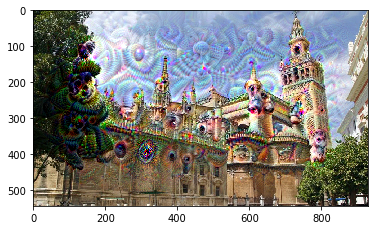

In [14]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()